# 2. Face Recognition

In [1]:
import os
from glob import glob
import numpy as np
import random
from random import shuffle
import imageio
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from skimage.transform import resize
from scipy.stats import multivariate_normal
np.random.seed(0)
random.seed(0)

In [2]:
folder_path = 'Color_FERET_Database/' # main_folder path

In [3]:
subdirectory_paths = glob(folder_path+'*') # full path of all the sub-directories (subjects)
num_subjects = len(subdirectory_paths) # total number of sub-diretories (subjects)

In [4]:
train_percentage = 0.8 # train split percentage
total = 0              # total images in a database
total_train = 0        # total images in training set
total_test = 0         # total images in test set

for path in subdirectory_paths: # go through each sub-directory
    total_files = len(glob(path+'/*.ppm')) # read all ppm files in a sub-directory
    total += total_files
    total_train += int(total_files*train_percentage)
    total_test += total_files - int(total_files*train_percentage)

print('Total Train files: {}, Total Test Files: {}'.format(total_train, total_test))

Total Train files: 1603, Total Test Files: 426


Original Image file size is 768x512x3 (RGB). We will convert it into grayscale and downsample it by a factor of 4. So resized file size will be 192x128

In [5]:
W = 768
H = 512
downsample_factor = 4
H_d = int(H/downsample_factor)
W_d = int(W/downsample_factor)

X_train = np.zeros((W_d*H_d, total_train))
X_test  = np.zeros((W_d*H_d, total_test))
Y_train = np.zeros(total_train)
Y_test  = np.zeros(total_test)

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [7]:
train_counter = 0
test_counter = 0

subject_counter = 0
subject_frequency = np.zeros(len(subdirectory_paths))


for path in subdirectory_paths:  # go through each sub-directory

    file_names = glob(path+'/*.ppm')  # read all ppm files in a sub-directory
    shuffle(file_names)               # random shuffle file_names

    # check number of training images for a particular sub-directory (subject)
    train_set_size = int(len(file_names)*train_percentage) 
    subject_frequency[subject_counter] = train_set_size
    
    for i, file in enumerate(file_names):
        # read, convert-to-gray scale, resize, and normalize the image to 0-1
        img = resize(rgb2gray(imageio.imread(file)), (W_d,H_d), mode='constant') / 255
        
        # add either to train set or test set
        if i < train_set_size:
            X_train[:, train_counter] = img.ravel()
            Y_train[train_counter] = subject_counter
            train_counter += 1
        else:
            X_test[:, test_counter] = img.ravel()
            Y_test[test_counter] = subject_counter
            test_counter += 1

    subject_counter += 1
    
subject_frequency /= total_train

## 2.1 Principal Component Analysis

### 2.1.1 EigenFaces

The training set can be placed into a matrix X = [x1, x2, ..., xD] of size NxD, N being the total number of pixels in an image x and D being the total number of training images. Compute the principal components using the snap-shot method. Display the mean face and the first 10 Eigenfaces.

In [8]:
mean_face = np.mean(X_train, axis=1)
std_face = np.std(X_train, axis=1)

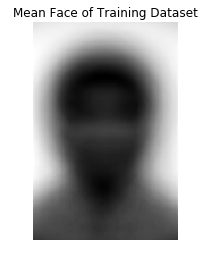

In [9]:
plt.imshow(mean_face.reshape((W_d,H_d)), cmap='gray')
plt.axis('off')
plt.title('Mean Face of Training Dataset')
plt.show()

In [10]:
X_train = (X_train.T - mean_face).T # subtract mean face from training dataset
#X_train = (X_train.T / std_face).T # divide by std face from training dataset

In [11]:
C_ = np.dot(X_train.T, X_train)                    # convert into DxD matrix, D = number of examples
eigen_values, eigen_vectors_V = np.linalg.eig(C_)  # get eigenvalues and eigenvectors for C_

eigen_vectors = (1/eigen_values) *   np.dot(X_train,eigen_vectors_V) # get eigenvectors for NxN matrix
eigen_vectors = normalize(eigen_vectors, axis=0) # normalize each eigenvectors to unit norm #   (1/np.sqrt(eigen_values)) *


# sort eigenvalues and its corresponding eigenvectors in descending order
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]
eigen_vectors_V = eigen_vectors_V[:,idx]

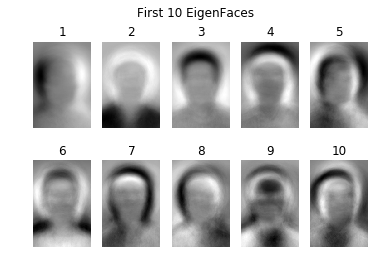

In [12]:
count = 1
for i in range(1,6):
    for j in range(1,3):
        plt.subplot(2,5,count)
        plt.imshow(eigen_vectors[:,count].reshape(W_d,H_d), cmap='gray')
        plt.axis('off')
        plt.title('{}'.format(count))
        count += 1


plt.suptitle('First 10 EigenFaces')
plt.show()

### 2.1.2 Number of Principal components required 

Decide on the number of principal components N_p required to represent the data. You can use either of the two methods for dimensionality estimation discussed in the class. Justify your choice and support it with an appropriate graph.

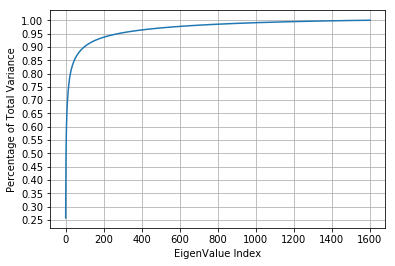

In [13]:
percentage_of_total_variance = eigen_values.cumsum()/eigen_values.sum()
plt.plot(percentage_of_total_variance)
plt.grid(True)
plt.yticks(np.arange(0.25, 1.01, step=0.05))
plt.xlabel('EigenValue Index')
plt.ylabel('Percentage of Total Variance')
plt.show()

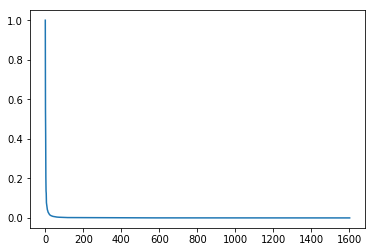

In [14]:
normalised_eigen_values = eigen_values / np.max(eigen_values)
plt.plot(normalised_eigen_values)
plt.show()

We can choose $N_p$ according to threshold on either total explained variacne or normalised eigen values. Threshold on total explained variance can be useful when we are trying to do face detection and want to use reconstruction of the faces. In this case as we are interested in face classification threshold on total explanied variance might not be useful. Similarly we can also see that eigen values are skewed, i.e. initial eigen values are comparatively really high then later eigen values. Due to this we will choose number of eigen vectors according to threshold on normalized eigen values. Specifically, we will choose threshold where normalized eigen values are >0.05.   

In [15]:
N_p = np.max(np.where(percentage_of_total_variance < 0.95)) + 2
print('Number of Prinicipal Components N_p required to represent data according to 0.95 total variance: {}'.format(N_p))

N_p = np.max(np.where(normalised_eigen_values > 0.05)) + 1
print('Number of Prinicipal Components N_p required to represent data according to 0.05 normalized eigen values: {}'.format(N_p))


Number of Prinicipal Components N_p required to represent data according to 0.95 total variance: 279
Number of Prinicipal Components N_p required to represent data according to 0.05 normalized eigen values: 10


## 2.2 Probabilistic Face Recognition

### 2.2.1 Using Bayes Rule, derive an expression for the posterior density of a subject label y for a given test image x*

$$
\begin{equation}
    P(y^* / \phi(x^*),\phi(X),Y) = \frac{P(\phi(x^*) / y^*,\phi(X),Y) \quad P(y^* / \phi(X),Y)}{P(\phi(x^*) / \phi(X),Y)}
\end{equation}
$$

$$
\begin{equation}
   \therefore P(y^* / \phi(x^*)) = \frac{P(\phi(x^*) / y^*,\phi(X),Y) \quad P(y^* / \phi(X),Y)}{\sum_{y^*} P(\phi(x^*) / y^*,\phi(X),Y) \quad P(y^* / \phi(X),Y)}
\end{equation}
$$

### 2.2.2 Find eigher representation phi(x) for each training image x i.e. project the image x on the first N_p Eigenfaces and find corresponding N_p coefficients. 

In [16]:
Top_eigenvectors = eigen_vectors[:,0:N_p]

In [17]:
# Projection of Training data onto Eigenspace
Proj_X_train = np.dot(X_train.T, Top_eigenvectors)

### 2.2.3 Build total 52 Gaussian density functions for the likelihood, one for each subject in the training set.

When we project the data into EigenSpace; overall data becomes uncorrelated, therefore 

In [18]:
Mean = np.zeros((num_subjects, N_p))
Covar = np.zeros((num_subjects, N_p, N_p))

# we will use scipy.stats.multivariate_normal to calcualte multivariate gaussian distribution.
# keep in mind that this function uses Pseudo Inverse and Pseudo Determinant of Cov matrix.
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

GDF = []
for i in range(num_subjects):
    Mean[i] = np.mean(Proj_X_train[np.equal(Y_train, i),:], axis=0)
    Covar[i] = np.cov(Proj_X_train[np.equal(Y_train, i),:].T) 
    GDF.append(multivariate_normal(mean=Mean[i], cov=Covar[i]))


### 2.3.4 Projection of test data into Eigenspace and its recognition 

In [19]:
X_test = (X_test.T - mean_face).T # subtract mean face from testing dataset
#X_test = (X_test.T / std_face).T # divide by std face from testing dataset

#### (i) Eigen Representation of X_test

In [20]:
Proj_X_test = np.dot(X_test.T, Top_eigenvectors)

#### (ii) Recognition using bayesian inference

In [21]:
#def mvgpdf(x, mean, covar):
#    dim = x.shape[1]
#
#    eig_values, _ = np.linalg.eig(covar)
#    pdet_cov = np.product(eig_values[eig_values > 1e-12])
#    
#    mult = (1/np.sqrt(((2*np.pi)**dim)*pdet_cov))
#
#    PInv_covar = np.linalg.pinv(covar)
#    x = x-mean
#    
#    return mult * np.exp(-np.sum(((x @ PInv_covar) * x),1))

In [22]:
Likelihood = np.zeros((num_subjects, Y_test.size))

In [23]:
for i in range(num_subjects):
    for j in range(Y_test.size):
        Likelihood[i, j] = GDF[i].pdf(Proj_X_test[j,:])

In [24]:
#for i in range(num_subjects):
#        Likelihood[i, :] = mvgpdf(Proj_X_test, Mean[i], Covar[i])

In [25]:
#Prior = np.ones((num_subjects, Y_test.size)) * 1/52 # equal prior
Prior = np.repeat(subject_frequency[:, np.newaxis], Y_test.size, axis=-1) # prior according to training dataset frequency

In [26]:
Marginal = Likelihood * Prior
Marginal = np.sum(Marginal, axis=0) # summation over classes for each subject 

In [27]:
Posterior = (Likelihood * Prior) / Marginal

In [28]:
Pred_Y_test_MAP = np.argmax(Posterior,axis=0)

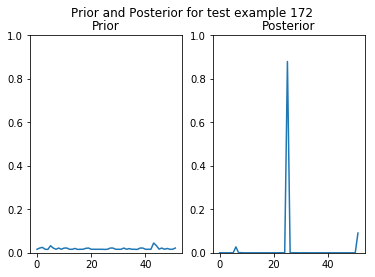

In [29]:
example_number = np.random.randint(0,Y_test.size)
plt.subplot(121)
plt.plot(Prior[:,example_number])
plt.ylim(0,1.0)
plt.title('Prior')
plt.subplot(122)
plt.plot(Posterior[:,example_number])
plt.ylim(0,1.0)
plt.title('Posterior')
plt.suptitle('Prior and Posterior for test example {}'.format(example_number))
plt.show()

#### (iii) Recognition using Nearest Neighbours

In [30]:
pairwise_diff = np.sum((Proj_X_train.reshape(-1,1,N_p) - Proj_X_test.reshape(1,-1,N_p))**2,2)
closest_train_point = np.argmin(pairwise_diff,axis=0)
Pred_Y_test_NN = Y_train[closest_train_point]

### 2.3.5 Accuracy of classification

In [31]:
MAP_accuracy = np.sum(Pred_Y_test_MAP == Y_test) / total_test

In [32]:
NN_accuracy = np.sum(Pred_Y_test_NN == Y_test) / total_test

In [33]:
print("Accuracy of MAP based method: {}".format(MAP_accuracy))

Accuracy of MAP based method: 0.5751173708920188


In [34]:
print("Accuracy of NN based method: {}".format(NN_accuracy))

Accuracy of NN based method: 0.676056338028169


From above results, we can see that NN based method is able to give better performance in comparison to MAP based method.